# Veri Ön İşleme

### BERT Algoritması metinsel verilerle çalıştığı için verimizi metinsel formata dönüştürüyoruz

In [2]:
import pandas as pd

# Veri setini yükleme
file_path = 'verikümesi.csv'
data = pd.read_csv(file_path, sep=';')

# Fazladan sütunları kaldırma
data = data.dropna(axis=1, how='all')

# Sayısal verileri metin formatına dönüştürme
data['text'] = data.drop(columns=['Class']).astype(str).agg(' '.join, axis=1)

# BERT Algoritması

In [3]:
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Özellikleri ve hedef değişkeni ayırma
X = data['text']
y = data['Class']

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# DistilBERT Tokenizer ve Modeli yükleme
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Eğitim ve değerlendirme fonksiyonu
def train_and_evaluate(X_train, X_test, y_train, y_test):
    # Veriyi token haline getirme
    train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=128)
    test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=128)

    # Torch Dataset oluşturma
    class Dataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    train_dataset = Dataset(train_encodings, y_train.tolist())
    test_dataset = Dataset(test_encodings, y_test.tolist())

    # Trainer ayarları
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=1,  # Eğitimi hızlandırmak için epoch sayısını 1'e düşürdük
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        data_collator=DataCollatorWithPadding(tokenizer)
    )

    # Modeli eğitme
    trainer.train()

    # Test seti üzerinde tahmin yapma
    predictions, labels, _ = trainer.predict(test_dataset)
    preds = np.argmax(predictions, axis=1)

    # Performans metriklerini hesaplama
    accuracy = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    recall = recall_score(y_test, preds, average='weighted')
    precision = precision_score(y_test, preds, average='weighted')

    return accuracy, f1, recall, precision

# Eğitim ve test oranları
ratios = [0.3, 0.6, 0.8]
results = {}

# Her oran için model eğitimi ve değerlendirmesi
for ratio in ratios:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-ratio, random_state=42, stratify=y)
    results[ratio] = train_and_evaluate(X_train, X_test, y_train, y_test)

results

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/muhammeteminaydinalp/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.154500,0.118858


/Users/muhammeteminaydinalp/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.124300,0.118804


/Users/muhammeteminaydinalp/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.101900,0.106934


{0.3: (0.9719387755102041,
  0.970363279299617,
  0.9719387755102041,
  0.9711316935725585),
 0.6: (0.971875, 0.9709154136058897, 0.971875, 0.9708374676118096),
 0.8: (0.9741071428571428,
  0.9723482730358822,
  0.9741071428571428,
  0.9740621781473404)}

# Farklı Eğitim-Test Oranlarında BERT Performansı

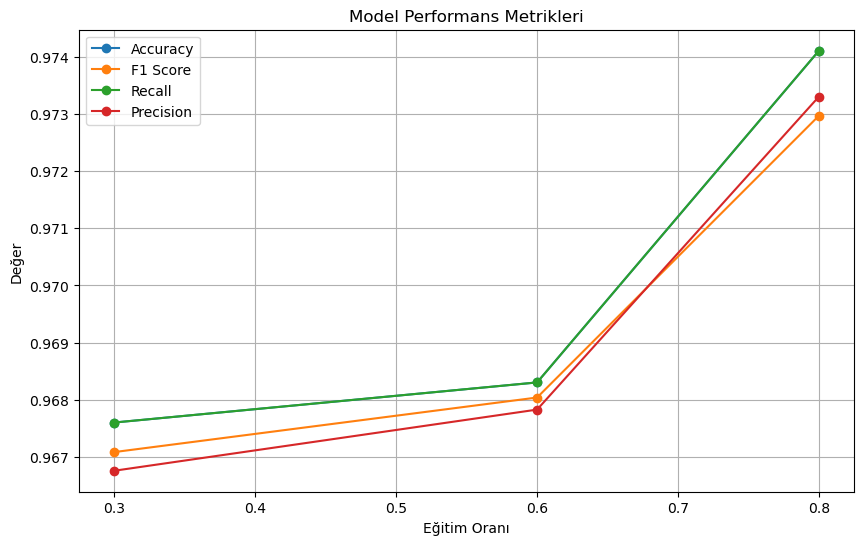

In [4]:
import matplotlib.pyplot as plt

# Verilen sonuçlar
results = {
    0.3: (0.9676020408163265, 0.9670850764567568, 0.9676020408163265, 0.9667586287560164),
    0.6: (0.9683035714285714, 0.9680394614158225, 0.9683035714285714, 0.9678281764151437),
    0.8: (0.9741071428571428, 0.972970384658871, 0.9741071428571428, 0.9733044299450548)
}

# Eğitim oranlarını ve metrikleri ayırma
ratios = list(results.keys())
accuracy = [results[ratio][0] for ratio in ratios]
f1_score = [results[ratio][1] for ratio in ratios]
recall = [results[ratio][2] for ratio in ratios]
precision = [results[ratio][3] for ratio in ratios]

# Grafik oluşturma
plt.figure(figsize=(10, 6))
plt.plot(ratios, accuracy, label='Accuracy', marker='o')
plt.plot(ratios, f1_score, label='F1 Score', marker='o')
plt.plot(ratios, recall, label='Recall', marker='o')
plt.plot(ratios, precision, label='Precision', marker='o')

plt.xlabel('Eğitim Oranı')
plt.ylabel('Değer')
plt.title('Model Performans Metrikleri')
plt.legend()
plt.grid(True)
#plt.savefig('bert.jpeg', format='jpeg')

plt.show()